# Learning Trajectory Parameters With Variational Autoencoders

This doc investigates whether a variational autoencoder can learn the physical parameters of a trajectory. Trajectories are generated using a set of parameters: initial_x, initial_y, initial_vx, and initial_vy. Given these input parameters, a simulation is run that creates a trajectory. Trajectories were generated from https://github.com/willbryk720/autoencoder-physics/blob/master/generate_trajectories.py


(The variational encoder class of this code was based on Jan Metzen's blog post here: https://jmetzen.github.io/2015-11-27/vae.html.)

In [0]:
import numpy as np
import tensorflow as tf
from random import randint
import os

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from skimage import io


np.random.seed(0)
tf.set_random_seed(0)

### Defining Variational Autoencoder Class

Define a class "VariationalAutoencoder" with a [sklearn](http://scikit-learn.org)-like interface that can be trained incrementally with mini-batches using partial_fit. The trained model can be used to reconstruct unseen input, to generate new samples, and to map inputs to the latent space.

In [0]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
           
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

Define a fuction which trains the VAE using mini-batches:

In [0]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs = next_batch(x_train, batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

### Helpful functions for getting image data and accessing it

In [0]:
# Loads the images from a local folder in the google drive. Returns an array of the images, representing the dataset
def get_data_from_folder(local_path_to_folder, image_type = "png", as_grey = True, display_num_images = 0):
    list_of_imgs = []
    img_dir = local_path_to_folder
    n_images = len(os.listdir(local_path_to_folder))
    print ("Scanning: " + str(n_images) + " images...")
    
    for i, img in enumerate(os.listdir(local_path_to_folder)):
        img = os.path.join(img_dir, img)
        if not img.endswith("." + image_type):
            continue

        image = io.imread(img, as_grey=as_grey)
        list_of_imgs.append(image)

        display_every_n = n_images/display_num_images if display_num_images != 0 else -1
        if display_every_n != -1 and i % (display_every_n) == 0:
            print (image.shape)
            plt.imshow(image)
            plt.show()
    
    return np.array(list_of_imgs)
  
# Splits images into x_train and x_test datasets
def get_xtrain_and_xtest(data, fraction_train):
    data_len = len(data)
    cutoff = int(fraction_train * data_len)
    return data[:cutoff], data[cutoff:]

  
def next_batch(arr, n_samples):
  arr_len = len(arr)
  lst = []
  for i in range(n_samples):
    rand_index = randint(0,arr_len - 1)
    lst.append(arr[rand_index])
  return np.array(lst)

In [7]:
# Clone the git repo that contains the image dataset. If it already exists than git pull from it
# Found this to be the easiest way to load images into google collab!
#
!git clone https://github.com/willbryk720/autoencoder-physics.git
#!cd autoencoder-physics; git pull

Cloning into 'autoencoder-physics'...
remote: Enumerating objects: 35052, done.
remote: Counting objects: 100% (35052/35052), done.
remote: Compressing objects: 100% (35044/35044), done.
remote: Total 35052 (delta 6), reused 35045 (delta 3), pack-reused 0
Receiving objects: 100% (35052/35052), 18.66 MiB | 26.68 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Checking out files: 100% (30003/30003), done.


#Experiment 1
What if only the initial_vy and the initial_vx were varied. The ball always starts at initial_x = 0, initial_y = 0. So the ball follows a parabolic trajectory.

Trajectories were generated using:

*   initial_x = 0
*   initial_y = 0
*  initial_vy = random.random()*100 + 30
* initial_vx = random.random()*50 + 20

In [13]:
vx_vy_images = get_data_from_folder("./autoencoder-physics/vx_vy/images", "png", display_num_images = 0)
x_train, x_test = get_xtrain_and_xtest(vx_vy_images, .8)

Scanning: 20000 images...


TypeError: ignored

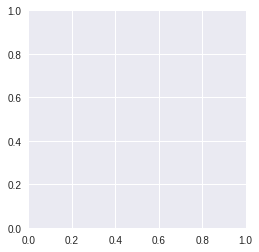

In [27]:
# Show example trajectory image
plt.imshow((x_train)[2])


In [28]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = 1 - x_train  # bc want black background and its stored with white background
x_test = 1 - x_test

# Reshape train and test data into vectors of length len(x_train)*len(x_train)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
n_samples = len(x_train)
print (x_train.shape)
print (x_test.shape)

(16000, 784)
(4000, 784)


## Illustrating reconstruction quality

We can now train a VAE on MNIST by just specifying the network topology. We start with training a VAE with a 20-dimensional latent space.

In [17]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

# vae = train(network_architecture, training_epochs=25)
vae = train(network_architecture, training_epochs=75)

Epoch: 0001 cost= 121.115063572
Epoch: 0006 cost= 66.249737215
Epoch: 0011 cost= 57.791995025
Epoch: 0016 cost= 54.895611978
Epoch: 0021 cost= 53.396619987
Epoch: 0026 cost= 52.324401402
Epoch: 0031 cost= 51.680657601
Epoch: 0036 cost= 51.063476205
Epoch: 0041 cost= 50.568040180
Epoch: 0046 cost= 49.937162423
Epoch: 0051 cost= 49.901229858
Epoch: 0056 cost= 49.570245767
Epoch: 0061 cost= 49.105056930
Epoch: 0066 cost= 49.053025317
Epoch: 0071 cost= 49.123209763


In [34]:
print(x_train[2].shape)
print(np.random.rand(784,).shape)

(784,)
(784,)


Based on this we can sample some test inputs and visualize how well the VAE can reconstruct those. In general the VAE does really well.

(100, 784)


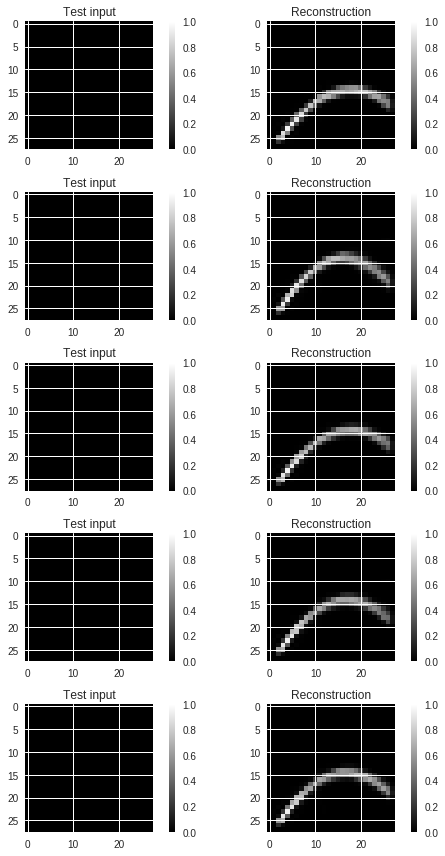

In [38]:
def createImageArrayForReconstruction(originalImage):
  arr = []
  for i in range(100):
      arr.append(originalImage)
  return np.array(arr)

new_image = np.zeros(784,)
x_sample = createImageArrayForReconstruction(new_image)

# x_sample = next_batch(x_test, 100)
# x_sample.shape
x_reconstruct = vae.reconstruct(x_sample)

sample_zmus = vae.transform(x_sample)
print(vae.generate(z_mu=sample_zmus).shape)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    plt.tight_layout()

## Illustrating latent space

Here we generate an image from the latent space by choosing a 2d vector in the latent space and running the decoder on it.

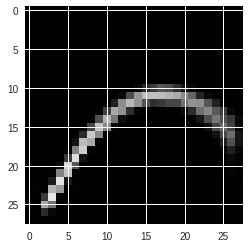

In [0]:
# Create decoded image from single 2d vecor input
def create_image_from_zmu(z_mu):
    lst = []
    for i in range(100):
        lst.append(z_mu)
    
    z_mus = np.array(lst)
    image_vector = vae.generate(z_mu=z_mus)[0]
    
    plt.imshow(image_vector.reshape(28, 28), vmin=0, vmax=1, cmap="gray")

# Create image from one latent vector
create_image_from_zmu([0.5,0.0])

Here we generate a set of images over a whole region of the latent space (the center of the latent space).

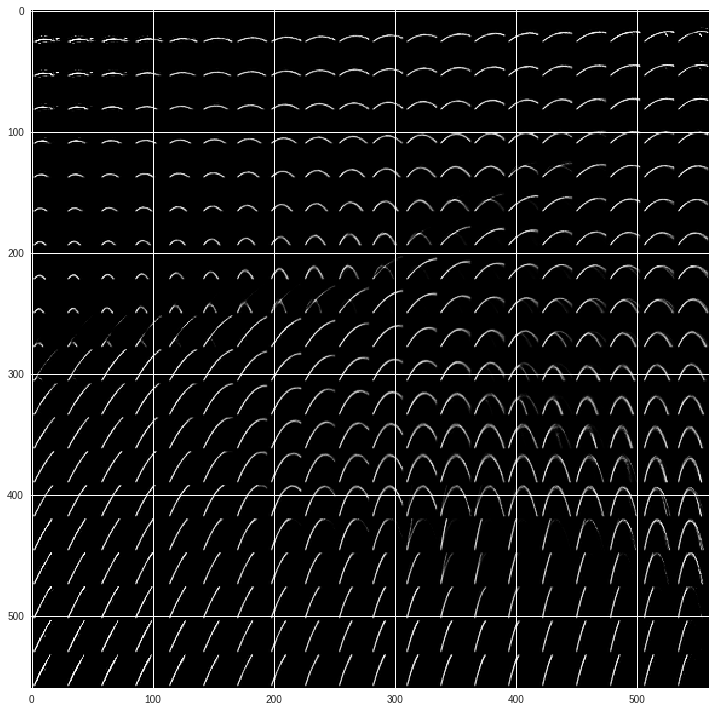

In [0]:
nx = ny = 20
x_values = np.linspace(-2, 2, nx)
y_values = np.linspace(-2, 2, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(10, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()



#Experiment 2
What if only the initial_y and the initial_vx were varied. It's like throwing a ball at various heights off a cliff with different x velocities.

Trajectories were generated using:

*   initial_x = 0
*   initial_y = 50 + random.random()*(IMAGE_HEIGHT - 50)
*  initial_vy = 0
* initial_vx = random.random()*50 + 20

In [0]:
vx_h_images = get_data_from_folder("./autoencoder-physics/vx_h/images", "png", display_num_images = 0)
x_train, x_test = get_xtrain_and_xtest(vx_h_images, .8)

Scanning: 10000 images...


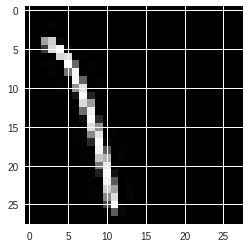

In [0]:
# Show example trajectory image
plt.imshow((x_train)[2])

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = 1 - x_train  # bc want black background and its stored with white background
x_test = 1 - x_test

# Reshape train and test data into vectors of length len(x_train)*len(x_train)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
n_samples = len(x_train)
print (x_train.shape)
print (x_test.shape)

(8000, 784)
(2000, 784)


## Illustrating reconstruction quality

We can now train a VAE on MNIST by just specifying the network topology. We start with training a VAE with a 20-dimensional latent space.

In [0]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

# vae = train(network_architecture, training_epochs=25)
vae = train(network_architecture, training_epochs=75)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 cost= 116.746309662
Epoch: 0006 cost= 74.908856678
Epoch: 0011 cost= 67.072957182
Epoch: 0016 cost= 58.285861683
Epoch: 0021 cost= 51.683402109
Epoch: 0026 cost= 49.095924616
Epoch: 0031 cost= 47.306394053
Epoch: 0036 cost= 46.249533701
Epoch: 0041 cost= 45.187618780
Epoch: 0046 cost= 44.367615652
Epoch: 0051 cost= 43.511148739
Epoch: 0056 cost= 42.937428331
Epoch: 0061 cost= 42.343672085
Epoch: 0066 cost= 41.962746143
Epoch: 0071 cost= 41.317990875


Based on this we can sample some test inputs and visualize how well the VAE can reconstruct those. In general the VAE does really well.

(100, 784)


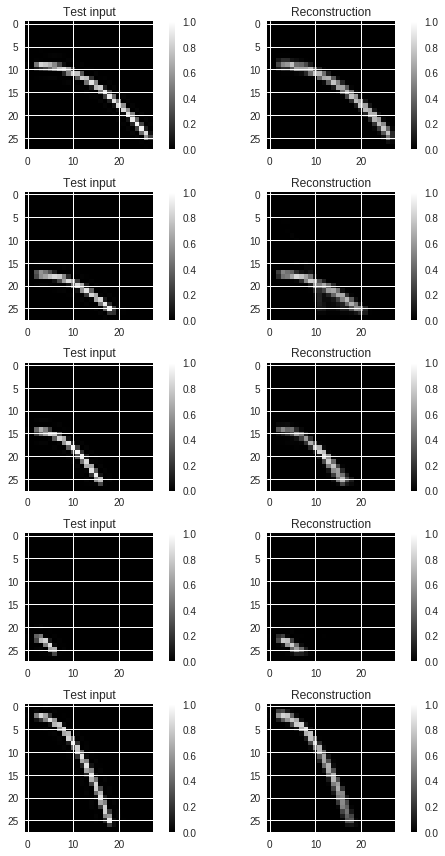

In [0]:
x_sample = next_batch(x_test, 100)
x_sample.shape
x_reconstruct = vae.reconstruct(x_sample)

sample_zmus = vae.transform(x_sample)
print(vae.generate(z_mu=sample_zmus).shape)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    plt.tight_layout()

## Illustrating latent space

Here we generate an image from the latent space by choosing a 2d vector in the latent space and running the decoder on it.

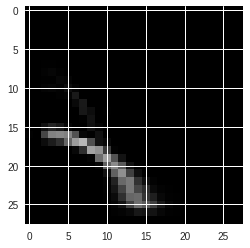

In [0]:
def create_image_from_zmu(z_mu):
    lst = []
    for i in range(100):
        lst.append(z_mu)
    
    z_mus = np.array(lst)
    image_vector = vae.generate(z_mu=z_mus)[0]
    
    plt.imshow(image_vector.reshape(28, 28), vmin=0, vmax=1, cmap="gray")

# Create image from one latent vector
create_image_from_zmu([0.5,0.0])

Here we generate a set of images over a whole region of the latent space (the center of the latent space).

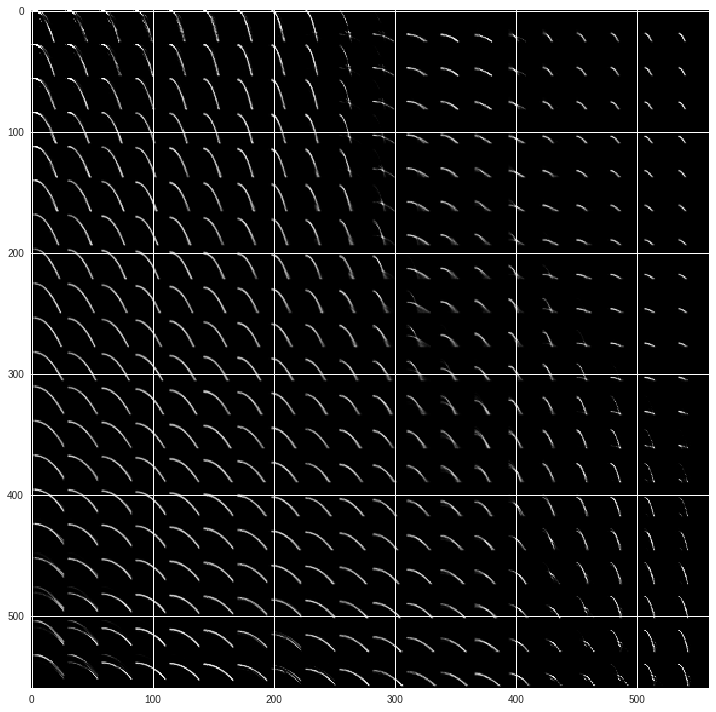

In [0]:
nx = ny = 20
x_values = np.linspace(-2, 2, nx)
y_values = np.linspace(-2, 2, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(10, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

